In [34]:
import h5py
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
import matplotlib
import scipy.integrate as integrate
from scipy.interpolate import UnivariateSpline as spl
from struct import unpack
from scipy import stats 
from astropy.cosmology import Planck15, FlatLambdaCDM, z_at_value
from astropy import coordinates as coord
import healpy as hp
import sys,os
import datetime

In [15]:
# define particle datatype
vect = np.dtype([('x', np.float32),('y', np.float32),('z', np.float32)])
part = np.dtype([('pos', vect),('vel', vect),('ID', np.ulonglong), ('z', np.float32), ('r', np.float32),('RA', np.float32),('Dec', np.float32)])

In [47]:
L = 3000  #boxsize
N = 2048  #number of particles **3
nfiles = 16
subfiles = 2 # NB not every core will output 2 subfiles.
z = 0.55 #redshift limit for lightcone
orig = 7 # origin of lightcone coordinate system for this buid, e.g, 0 = (0,0,0), 1 = (0.5,0.0,0.0), 7 = (0.5,0.5,0.5) etc, in units of BoxSize
nparts = 4000000000 # estimate of total particles in lightcone (will read headers to get exact count in future version)
p = np.empty(nparts, dtype=part)  #create empty array to hold all lightcone particles
fpath = '/cosma7/data/dp004/dc-boot5/Lightcone/Interpolated_Lightcone/redshift{0:0.2f}/Lightcone{1:0d}/'.format(z,orig)
#fpath = '/cosma7/data/dp004/dc-boot5/Lightcone/Interpolated_Lightcone/Lightcone{0:0d}/'.format(orig)
#fpath = '/cosma7/data/dp004/dc-boot5/Lightcone/Interpolated_Lightcone/'
n = 0 #particle counter
for fileno in range(nfiles):
    for sub in range(subfiles):
        fname = fpath + 'Planck2013-L{0:d}-N{1:d}-Fiducial-Lightcone.{2:d}.{3:d}'.format(L, N, fileno, sub)
        # Check that file actually exists for this snapshot
        if os.path.exists(fname):
            with h5py.File(fname,'r') as f:
                s = f['LC_Particles'].size
                p[n:n+s] = f['LC_Particles']
                n += s
            print('File {0:d}.{1:d} read, time = {2:%H:%M:%S}'.format(fileno, sub, datetime.datetime.now()))
        else:
             print('Lightcone file {0:d}.{1:d} does not exist'.format(fileno, sub))
print('Finished reading in {0:d} particles'.format(n))

File 0.0 read, time = 20:06:03
File 0.1 read, time = 20:06:37
File 1.0 read, time = 20:07:13
Lightcone file 1.1 does not exist
File 2.0 read, time = 20:07:13
File 2.1 read, time = 20:07:49
File 3.0 read, time = 20:08:23
Lightcone file 3.1 does not exist
File 4.0 read, time = 20:08:23
File 4.1 read, time = 20:09:04
File 5.0 read, time = 20:09:44
Lightcone file 5.1 does not exist
File 6.0 read, time = 20:10:32
Lightcone file 6.1 does not exist
File 7.0 read, time = 20:10:32
File 7.1 read, time = 20:11:10
File 8.0 read, time = 20:11:10
File 8.1 read, time = 20:11:48
File 9.0 read, time = 20:11:48
File 9.1 read, time = 20:12:24
File 10.0 read, time = 20:13:01
Lightcone file 10.1 does not exist
File 11.0 read, time = 20:13:01
File 11.1 read, time = 20:13:42
File 12.0 read, time = 20:14:29
Lightcone file 12.1 does not exist
File 13.0 read, time = 20:14:29
File 13.1 read, time = 20:15:16
File 14.0 read, time = 20:16:11
Lightcone file 14.1 does not exist
File 15.0 read, time = 20:16:11
File 15

In [49]:
p = p[:n]

In [50]:
p.shape #number of particles in lightcone

(3905758632,)

In [62]:
# take a z-plane slice through lightcone for viewing
depth = 5
p_slice = p[abs(p['pos']['z'])< depth]

In [63]:
# view max and min values for particle coordinates
x = p_slice['pos']['x']
y = p_slice['pos']['y']
z = p_slice['pos']['z']
zz = p_slice['z']
r = p_slice['r']
np.array([[np.amin(x), np.amax(x)], [np.amin(y), np.amax(y)], [np.amin(z), np.amax(z)]])

array([[-1431.0162   ,  1430.988    ],
       [-1431.059    ,  1431.0538   ],
       [   -4.999999 ,     4.9999995]], dtype=float32)

In [74]:
x_max = np.amax(abs(x))
y_max = np.amax(abs(y))
r_min = np.amin(r)
r_max = np.amax(r)
z_max = np.amax(np.abs(z))
R_max = (r_max//200 +1) * 200
print(r_min, r_max, z_max, x_max, y_max, R_max)

0.0 1431.0806 0.55 1431.0162 1431.059 1600.0


In [75]:
# set density deposition mode
mode = 'NGP' #'CIC' #'NGP' # alternative is 'CIC'
size = 2000 # size of image array/2
X = x * size/x_max + size-1 # rescale x axis
Y = y * size/y_max + size-1 # rescale y axis

# Calculate cell in which each galaxy is located on 2D grid
i = np.floor(X)
j = np.floor(Y)
i = i.astype(int) # x index of cell that contains particle
j = j.astype(int) # y index of cell that contains particle

# define image mesh
img = np.full((2*size,2*size),0.0001)

# calcuate total density in each image grid cell by summing over all particles
for k,p_ in enumerate(p_slice):
    if mode=='CIC' and i[k]<2*size-1 and j[k]<2*size-1:
        d_x = X[k] - i[k]  # x offset of particle in cell
        d_y = Y[k] - j[k]  # y offset of particle in cell
        t_x = 1 - d_x
        t_y = 1 - d_y

        img[i[k],j[k]]    += t_x * t_y
        img[i[k]+1,j[k]]  += d_x * t_y
        img[i[k],j[k]+1]  += t_x * d_y
        img[i[k]+1,j[k]+1]+= d_x * d_y
    else:       # if NGP mode or on grid boundary
        img[i[k],j[k]]+= 1
        
L_max = np.amax(img)
L_min = np.amin(img)
print ('L_max = ', L_max, 'L_min = ', L_min)

L_max =  1256.0001 L_min =  0.0001


In [76]:
# set up colour map
cdict = {'red':   [[0.0, 0.0, 0.0],
                   [0.1, 0.0, 0.0],
                   [1.0, 1.0, 1.0]],
         'green': [[0.0, 0.0, 0.0],
                   [0.1, 0.0, 0.0],
                   [1.0, 1.0, 1.0]],
         'blue':  [[0.0, 0.0, 0.0],
                   [0.1, 1.0, 1.0],
                   [1.0, 0.2, 0.2]]}

cmap_name = 'blue1'
newcmp1 = LinearSegmentedColormap(cmap_name, segmentdata=cdict, N=256)

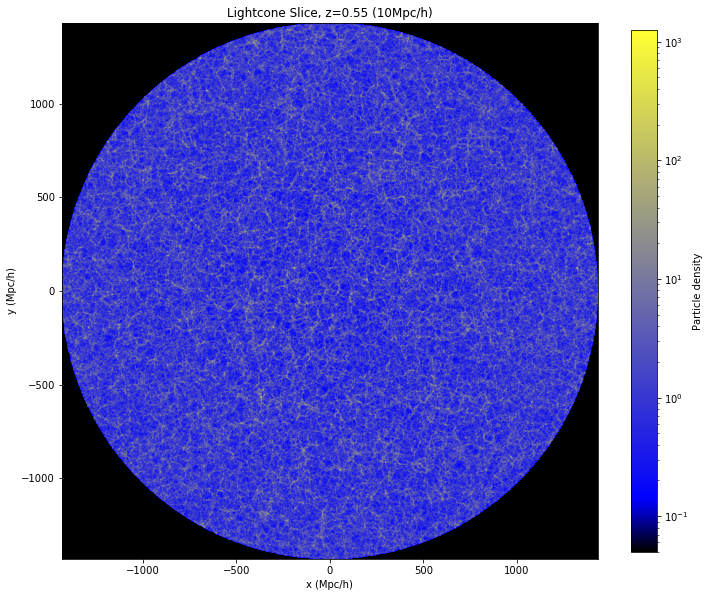

In [77]:
Dpi = 600
z = 0.55
Cmap = newcmp1
Cmap.set_under('k')
#Interp = 'None'
Interp = 'kaiser'
#Norm = cm.colors.Normalize(vmin=0.01, vmax=L_max)
#Norm = cm.colors.PowerNorm(gamma=0.1)
Norm = cm.colors.LogNorm(vmin=0.05, vmax=L_max)
ext = (-r_max, r_max, -r_max, r_max)
fig = plt.subplots(figsize = (12,12))
plt.imshow(img,  cmap = Cmap, norm = Norm, interpolation = Interp, extent = ext)
cbar = plt.colorbar(shrink = 0.8)
cbar.set_label('Particle density')
plt.xlabel('x (Mpc/h)')
plt.ylabel('y (Mpc/h)')
plt.title('Lightcone Slice, z={0:0.2f} (10Mpc/h)'.format(z))
plt.savefig('DM_Particle_Lightcone_Slice_z={5:n}_mode-{0:s}_interp-{1:s}_res-{2:0d}_dpi-{3:0d}_cmap-{4:s}.png'
            .format(mode,Interp, size*2, Dpi, Cmap.name,z),transparent = False, dpi = Dpi, bbox_inches = 'tight')
plt.show()

In [78]:
# create a shell slice thugh lightcone for Healpix projection
r_min = 800
r_max = 820
p_shell = p[(p['r']>r_min) & (p['r']<r_max)]

In [69]:
# Get pixel map
nside = 256
npix = hp.nside2npix(nside)
pix = hp.vec2pix(nside, p_shell['pos']['x'],p_shell['pos']['y'],p_shell['pos']['z'])
dens_map = np.histogram(pix, npix)[0]

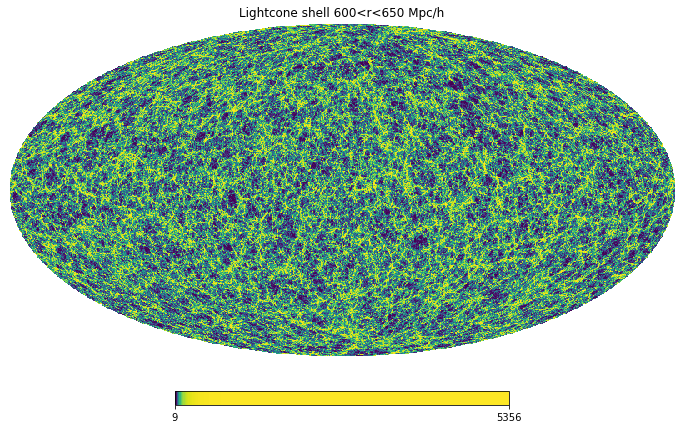

In [70]:
fig, ax = plt.subplots(1,1, figsize=(12,12))
hp.mollview(dens_map, norm = 'hist', title = 'Lightcone shell {0:0.0f}<r<{1:0.0f} Mpc/h'.format(r_min, r_max), hold=True, xsize = 800)
#plt.savefig('lightcone_shell_800-r-850.png')

In [71]:
v = np.sqrt(p['vel']['x']**2 + p['vel']['y']**2 + p['vel']['z']**2)
r = np.sqrt(p['pos']['x']**2 + p['pos']['y']**2 + p['pos']['z']**2)
vr = v *  np.sign(p['vel']['x'] + p['vel']['y'] + p['vel']['z'])

In [61]:
bin_means, bin_edges, binnumber = stats.binned_statistic(r, vr, statistic='mean', bins=1000)

In [80]:
bin_means1, bin_edges1, binnumber1 = stats.binned_statistic(r, v, statistic='mean', bins=1000)

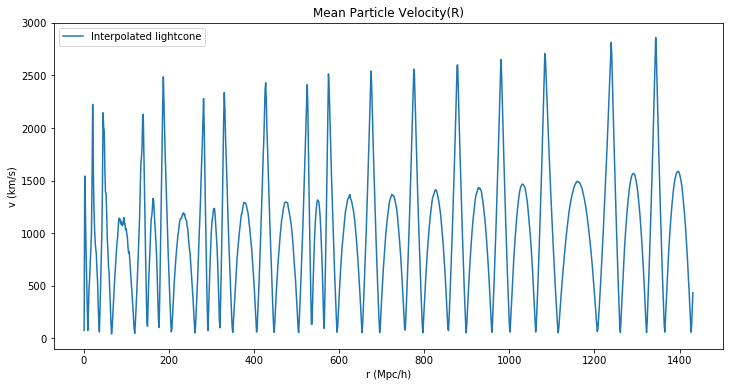

In [81]:
plt.figure(figsize = (12,6))
#plt.plot(bin_edges[1::], bin_means, label = 'Interpolated lightcone')
plt.plot(bin_edges1[1::], bin_means1, label = 'Interpolated lightcone')
plt.legend()
plt.xlabel('r (Mpc/h)')
plt.ylabel('v (km/s)')
plt.title('Mean Particle Velocity(R)')
plt.savefig('velocity_vs_r.png')
plt.show()

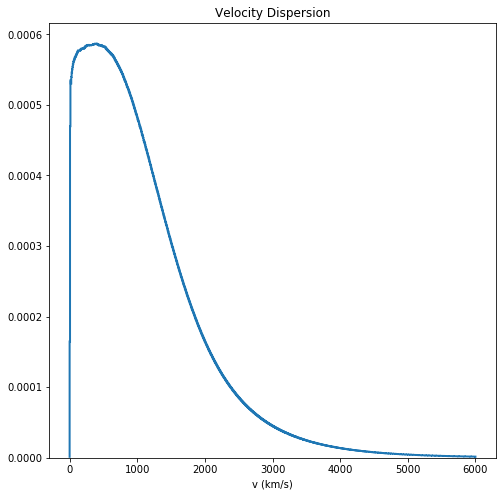

In [82]:
fig = plt.subplots(figsize = (8,8))
plt.hist(v , density=True, log=False, bins=1000, histtype='step', linewidth = 2, range = (0,6000)) 
plt.title('Velocity Dispersion')
plt.xlabel('v (km/s)')
plt.show()

In [56]:
# initialise cosmology
cosmo = FlatLambdaCDM(H0=100, Om0=0.30711520) 

In [59]:
cosmo.comoving_distance(1.45)

<Quantity 2973.68709807 Mpc>